## Inpainting with Variable Dataset Size

Recall that the Image网 dataset consists of:

1. A `/val` folder with 10 classes.
2. A `/train` folder with 20 classes. 
  - There are ~125 images in each class that exists in `/val`. There are 
  - There are ~1,300 images in each class that does not exist in `/val`
3. An `/unsup` folder with 7,750 unlabelled images.

The question we would like to answer with this notebook is:

> What is the effect of dataset size during pretext training on downstream task performance?

To answer this question we will consider four different datasets, each built from ImageWang.

They are:

1. All data in `/train`, `/unsup` and `/val`
2. All data in `/train`, `/unsup`
3. All data in `/train`
4. Only Data in `/train` that has a corresponding class in `/val`

In [1]:
import gc
import json
import torch
import numpy as np

from config import config
from RandomCutout import RandomCutout, PILImageInput

from fastai2.basics import *
from fastai2.vision.all import *

from torch.nn import MSELoss
from functools import partial

In [2]:
# Default parameters
lr=config['lr']
size=config['size']
sqrmom=config['sqrmom']
mom=config['mom']
eps=config['eps']
epochs=config['epochs']
bs=config['bs']
opt=config['opt']
sh=config['sh']
sa=config['sa']
sym=config['sym']
beta=config['beta']
act_fn=config['act_fn']
fp16=config['fp16']
pool=config['pool']
runs=config['runs']

model = config['model']

if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)
    
size = 128
bs = 64
runs=3

In [3]:
print("lr", lr)
print("size", size)
print("sqrmom", sqrmom)
print("mom", mom)
print("eps", eps)
print("epochs", epochs)
print("bs", bs)
print("opt", opt)
print("sh", sh)
print("sa", sa)
print("sym", sym)
print("beta", beta)
print("act_fn", act_fn)
print("fp16", fp16)
print("pool", pool)
print("runs", runs)
print("model", model)

lr 0.008
size 128
sqrmom 0.99
mom 0.9
eps 1e-06
epochs 15
bs 64
opt ranger
sh 0.0
sa 0
sym 0
beta 0.0
act_fn <class 'fastai2.layers.Mish'>
fp16 0
pool <function MaxPool at 0x7f87caaece60>
runs 3
model <function xresnet34 at 0x7f87ca8fa8c0>


## Get Items From Folder

So before we do anything, let's create some helper methods that will give us only the training sets that we would like.

In [4]:
source = untar_data(URLs.IMAGEWANG_160)

In [5]:
# transforms are the same for each experiment
item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5), RandomCutout]
batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None

In [6]:
def get_all_items(path):
    return get_files(path, extensions='.JPEG', recurse=True)

def get_train_items(path):
    return get_files(path/'train', extensions='.JPEG', recurse=True)

def get_unsup_items(path):
    return get_files(path/'unsup', extensions='.JPEG', recurse=True)

def get_valid_items(path):
    return get_files(path/'val', extensions='.JPEG', recurse=True)

def get_train_and_unsup(path):
    return get_train_items(path) + get_unsup_items(path)

def get_train_items_that_are_present_in_val(path):
    """
    We first get a list of all classes in /val
    Then we use that list to get all the examples of each class from /train
    """
    val = source/'val'
    validation_classes = [path.name for path in val.iterdir()]
    
    train_files = L()
    for class_name in validation_classes:
        items = get_files(path/'train'/class_name, extensions='.JPEG', recurse=True)
        train_files = train_files + items
        
    return train_files

all_items = get_all_items(untar_data(URLs.IMAGEWANG_160))
train_items = get_train_items(untar_data(URLs.IMAGEWANG_160))
unsup_items = get_unsup_items(untar_data(URLs.IMAGEWANG_160))
valid_items = get_valid_items(untar_data(URLs.IMAGEWANG_160))

print("All Files:\t{}".format(len(all_items)))
print("Train Files:\t{}".format(len(train_items)))
print("Unsup Files:\t{}".format(len(unsup_items)))
print("Valid Files:\t{}".format(len(valid_items)))
print()

train_and_unsup_items = get_train_and_unsup(untar_data(URLs.IMAGEWANG_160))
print("Train+Unsup Files: {}".format(len(train_and_unsup_items)))
train_in_valid_items = get_train_items_that_are_present_in_val(untar_data(URLs.IMAGEWANG_160))
print("Train(in validation set)+Unsup Files: {}".format(len(train_in_valid_items)))

All Files:	26348
Train Files:	14669
Unsup Files:	7750
Valid Files:	3929

Train+Unsup Files: 22419
Train(in validation set)+Unsup Files: 1275


## Train with all data in `/train`, `/unsup` and `/val`

In [7]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   splitter=RandomSplitter(valid_pct=0),
                   get_items=get_all_items, 
                   get_y=lambda o: o,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

dbunch =  dblock.dataloaders(source, path=source, bs=bs)

#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

print("Training Size:", len(dbunch.train_ds))
print("Validation Size:", len(dbunch.valid_ds))

Training Size: 26348
Validation Size: 0


In [8]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), 'all_train_unsup_val_pretext_{}.pth'.format(run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.016735,None,02:34
1,0.005480,None,02:30
2,0.004872,None,02:30
3,0.004522,None,02:30
4,0.004380,None,02:30
5,0.004298,None,02:30
6,0.004284,None,02:30
7,0.004252,None,02:30
8,0.004163,None,02:30
9,0.004135,None,02:30


/home/josh/anaconda3/envs/fastai2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,0.016650,None,02:30
1,0.005430,None,02:30
2,0.004920,None,02:30
3,0.004689,None,02:30
4,0.004529,None,02:30
5,0.004477,None,02:30
6,0.004304,None,02:30
7,0.004278,None,02:30
8,0.004193,None,02:30
9,0.004143,None,02:30


epoch,train_loss,valid_loss,time
0,0.017128,None,02:30
1,0.005302,None,02:30
2,0.004838,None,02:30
3,0.004739,None,02:30
4,0.004560,None,02:30
5,0.004536,None,02:30
6,0.004400,None,02:30
7,0.004351,None,02:30
8,0.004241,None,02:30
9,0.004143,None,02:30


## Train with all data in `/train` and `/unsup`

In [9]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   splitter=RandomSplitter(valid_pct=0),
                   get_items=get_train_and_unsup, 
                   get_y=lambda o: o,
                   item_tfms=item_tfms, 
                   batch_tfms=batch_tfms)

dbunch =  dblock.dataloaders(source, path=source, bs=bs)

#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

print("Training Size:", len(dbunch.train_ds))
print("Validation Size:", len(dbunch.valid_ds))

Training Size: 22419
Validation Size: 0


In [10]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), 'all_train_unsup_pretext_{}.pth'.format(run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.039221,None,02:08
1,0.005747,None,02:08
2,0.005353,None,02:08
3,0.005068,None,02:08
4,0.004822,None,02:08
5,0.004581,None,02:08
6,0.004599,None,02:08
7,0.004477,None,02:08
8,0.004373,None,02:08
9,0.004322,None,02:08


epoch,train_loss,valid_loss,time
0,0.038902,None,02:08
1,0.005771,None,02:08
2,0.005489,None,02:08
3,0.005071,None,02:08
4,0.004872,None,02:08
5,0.004596,None,02:08
6,0.004538,None,02:08
7,0.004442,None,02:08
8,0.004372,None,02:08
9,0.004342,None,02:08


epoch,train_loss,valid_loss,time
0,0.039105,None,02:08
1,0.005674,None,02:08
2,0.005298,None,02:08
3,0.004939,None,02:08
4,0.004763,None,02:08
5,0.004596,None,02:08
6,0.004536,None,02:08
7,0.004641,None,02:08
8,0.004362,None,02:08
9,0.004354,None,02:08


## Train with all data in `/train`

In [11]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   splitter=RandomSplitter(valid_pct=0),
                   get_items=get_train_items, 
                   get_y=lambda o: o,
                   item_tfms=item_tfms, 
                   batch_tfms=batch_tfms)

dbunch =  dblock.dataloaders(source, path=source, bs=bs)

#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

print("Training Size:", len(dbunch.train_ds))
print("Validation Size:", len(dbunch.valid_ds))

Training Size: 14669
Validation Size: 0


In [12]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), 'all_train_pretext_{}.pth'.format(run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.185480,None,01:24
1,0.010443,None,01:24
2,0.005977,None,01:24
3,0.006075,None,01:24
4,0.005620,None,01:24
5,0.005190,None,01:24
6,0.005272,None,01:24
7,0.005040,None,01:24
8,0.004982,None,01:24
9,0.004757,None,01:24


epoch,train_loss,valid_loss,time
0,0.184486,None,01:24
1,0.010486,None,01:24
2,0.006268,None,01:24
3,0.005693,None,01:24
4,0.005413,None,01:24
5,0.005430,None,01:24
6,0.005210,None,01:24
7,0.005036,None,01:24
8,0.005011,None,01:24
9,0.004929,None,01:24


epoch,train_loss,valid_loss,time
0,0.184661,None,01:24
1,0.010222,None,01:24
2,0.006018,None,01:24
3,0.005746,None,01:24
4,0.005596,None,01:24
5,0.005327,None,01:24
6,0.005002,None,01:24
7,0.004956,None,01:24
8,0.004934,None,01:24
9,0.004931,None,01:24


## Train with partial data from `/train`

In [10]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   splitter=RandomSplitter(valid_pct=0),
                   get_items=get_train_items_that_are_present_in_val, 
                   get_y=lambda o: o,
                   item_tfms=item_tfms, 
                   batch_tfms=batch_tfms)

dbunch =  dblock.dataloaders(source, path=source, bs=bs)

#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

print("Training Size:", len(dbunch.train_ds))
print("Validation Size:", len(dbunch.valid_ds))

Training Size: 1275
Validation Size: 0


In [11]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), 'partial_train_pretext_{}.pth'.format(run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()

epoch,train_loss,valid_loss,time
0,0.928153,None,00:07
1,0.813562,None,00:07
2,0.741672,None,00:07
3,0.675520,None,00:07
4,0.610155,None,00:07
5,0.543690,None,00:07
6,0.477957,None,00:07
7,0.414091,None,00:07
8,0.354247,None,00:07
9,0.298382,None,00:07


epoch,train_loss,valid_loss,time
0,0.925984,None,00:07
1,0.812690,None,00:07
2,0.739564,None,00:07
3,0.674601,None,00:07
4,0.608644,None,00:07
5,0.542074,None,00:07
6,0.477865,None,00:08
7,0.414007,None,00:07
8,0.353446,None,00:07
9,0.297540,None,00:07


epoch,train_loss,valid_loss,time
0,0.921843,None,00:08
1,0.812477,None,00:07
2,0.741308,None,00:07
3,0.675774,None,00:08
4,0.610134,None,00:08
5,0.543442,None,00:07
6,0.477867,None,00:07
7,0.414159,None,00:07
8,0.353886,None,00:07
9,0.298228,None,00:07


# Downstream Task: Image网

Now that we've trained models on our pretext tasks, let's compare the performance of each model against one another.

In [12]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=item_tfms, batch_tfms=batch_tfms)
    
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [14]:
dbunch = get_dbunch(size, bs)

## Random Baseline

In [15]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)
        
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.796687,3.636446,0.012217,0.296768,00:18
1,1.550067,3.181229,0.056757,0.467804,00:18
2,1.426739,4.102186,0.005345,0.191652,00:18
3,1.324669,3.096211,0.107406,0.500127,00:18
4,1.261578,3.208763,0.083736,0.473403,00:18
5,1.204970,2.567671,0.252482,0.739883,00:18
6,1.151186,2.390353,0.305930,0.771443,00:18
7,1.118767,2.636642,0.242555,0.693306,00:18
8,1.100804,2.697914,0.257826,0.692543,00:18
9,1.048302,2.673872,0.265716,0.694070,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.785860,3.457567,0.030288,0.337745,00:18
1,1.537349,3.515796,0.020870,0.392975,00:18
2,1.418070,2.866719,0.103080,0.630186,00:19
3,1.327588,3.035241,0.114278,0.566302,00:19
4,1.240670,3.118759,0.132349,0.656401,00:18
5,1.239033,2.498254,0.243573,0.766098,00:19
6,1.161790,2.439876,0.287350,0.780606,00:19
7,1.111243,2.615522,0.255027,0.702723,00:18
8,1.071862,2.776183,0.236192,0.689488,00:18
9,1.047892,2.640335,0.266989,0.689997,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.787773,3.516780,0.007636,0.366251,00:18
1,1.567964,3.588476,0.029270,0.306439,00:17
2,1.430103,3.278402,0.076101,0.526343,00:18
3,1.358013,3.461002,0.053449,0.433189,00:18
4,1.265356,3.048952,0.119369,0.541614,00:18
5,1.195957,2.295239,0.340545,0.791550,00:17
6,1.158875,2.454480,0.286587,0.757445,00:17
7,1.128101,2.198237,0.373886,0.825655,00:18
8,1.066233,2.845231,0.219140,0.649784,00:19
9,1.052186,2.875170,0.240265,0.623059,00:18


Results:
- Run 1: 0.523797
- Run 2: 0.514889
- Run 3: 0.529651

Average: **52.3%**


## All data in `/train`, `/unsup` and `/val`

In [16]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = 'all_train_unsup_val_pretext_' + str(run) + '.pth'
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.625774,3.095902,0.078646,0.489692,00:17
1,1.444291,2.837894,0.127768,0.628659,00:18
2,1.323350,3.941919,0.042250,0.542886,00:18
3,1.267578,3.100082,0.164418,0.588445,00:18
4,1.190820,2.658577,0.227030,0.714177,00:18
5,1.146419,2.336139,0.328582,0.795113,00:19
6,1.118836,2.850287,0.189107,0.712141,00:19
7,1.078408,2.145468,0.407228,0.847035,00:19
8,1.048037,2.526860,0.276661,0.741919,00:19
9,1.051319,2.374088,0.315856,0.797404,00:19


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.568926,3.201440,0.038941,0.481038,00:19
1,1.430129,3.079170,0.083482,0.520489,00:18
2,1.314956,3.455348,0.047849,0.501145,00:18
3,1.237833,3.630859,0.062866,0.410028,00:18
4,1.202348,3.706586,0.118860,0.519980,00:18
5,1.147139,2.649355,0.237720,0.727412,00:19
6,1.108960,2.339426,0.310766,0.813439,00:18
7,1.067904,2.263319,0.372359,0.828710,00:18
8,1.042159,2.021785,0.444133,0.875032,00:19
9,1.015093,2.671152,0.263171,0.723339,00:19


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.581555,3.089038,0.047086,0.465258,00:18
1,1.425198,3.232237,0.058794,0.478493,00:18
2,1.339247,2.751087,0.168236,0.620514,00:18
3,1.272282,2.690238,0.213286,0.664800,00:18
4,1.200665,3.445563,0.078391,0.573174,00:18
5,1.142999,2.443823,0.295495,0.752863,00:18
6,1.115349,2.237138,0.369051,0.809366,00:18
7,1.067307,2.606795,0.266989,0.720031,00:19
8,1.053232,2.296061,0.355307,0.792823,00:18
9,1.029087,2.112665,0.418682,0.855943,00:18


Results:
- Run 1: 0.567065
- Run 2: 0.567320
- Run 3: 0.555612

Average: **56.3%**


## All data in `/train` and `/unsup`

In [17]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = 'all_train_unsup_pretext_' + str(run) + '.pth'
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.602850,3.211928,0.061848,0.520234,00:17
1,1.428863,2.790500,0.163909,0.611097,00:18
2,1.336136,3.666106,0.029015,0.350725,00:17
3,1.241302,2.805484,0.166455,0.617460,00:18
4,1.177933,2.845249,0.185798,0.640876,00:18
5,1.162077,2.421694,0.289896,0.761517,00:18
6,1.103601,2.232995,0.351998,0.804785,00:18
7,1.069577,2.269675,0.362433,0.840672,00:18
8,1.045862,2.452979,0.330109,0.739374,00:18
9,1.016141,2.519302,0.300585,0.735811,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.638295,3.437557,0.021889,0.345890,00:18
1,1.447040,2.952383,0.118096,0.656401,00:18
2,1.340724,2.892893,0.145839,0.613388,00:18
3,1.264487,3.103402,0.131331,0.506236,00:18
4,1.203761,4.001534,0.045559,0.279969,00:17
5,1.159279,2.380309,0.320692,0.789005,00:18
6,1.105778,2.542387,0.278188,0.763808,00:18
7,1.080390,2.503495,0.301094,0.748028,00:19
8,1.028160,2.709562,0.254772,0.677526,00:18
9,1.036337,2.156838,0.396539,0.827182,00:19


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.637182,3.337158,0.039450,0.444897,00:18
1,1.439949,2.875855,0.114533,0.589718,00:19
2,1.333174,2.860575,0.152711,0.588445,00:19
3,1.239065,2.408661,0.277170,0.768643,00:18
4,1.223965,2.996097,0.143293,0.577501,00:18
5,1.162042,2.423923,0.281242,0.789768,00:18
6,1.113972,2.210407,0.362433,0.832782,00:18
7,1.091237,2.087266,0.423008,0.843217,00:18
8,1.047078,2.546793,0.274370,0.712904,00:18
9,1.014250,2.401478,0.301349,0.810893,00:18


Results:
- Run 1: 0.564011
- Run 2: 0.556121
- Run 3: 0.564520

Average: **56.2%**


## All data in `/train`

In [18]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = 'all_train_pretext_' + str(run) + '.pth'
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  


Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.627793,3.362736,0.022652,0.570629,00:19
1,1.451993,3.474679,0.048104,0.400611,00:19
2,1.344181,3.008803,0.116315,0.540596,00:19
3,1.264943,3.061157,0.107406,0.564775,00:19
4,1.212386,3.232984,0.115042,0.481802,00:18
5,1.154960,2.205971,0.365487,0.837618,00:19
6,1.115693,2.266136,0.325783,0.802494,00:19
7,1.080417,2.650732,0.261899,0.726648,00:18
8,1.053103,2.763943,0.212777,0.724103,00:19
9,1.021855,2.384633,0.340799,0.782133,00:19


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.628827,3.318213,0.043523,0.447697,00:18
1,1.447626,2.767823,0.147620,0.637567,00:19
2,1.355482,2.841080,0.156019,0.596589,00:18
3,1.271204,2.949238,0.164164,0.579537,00:19
4,1.218051,2.350754,0.322983,0.756172,00:19
5,1.166977,2.391598,0.317893,0.768389,00:19
6,1.136429,2.395736,0.324256,0.767625,00:19
7,1.077798,2.595934,0.262153,0.704759,00:19
8,1.054319,2.576859,0.273352,0.703741,00:19
9,1.022132,2.658796,0.260626,0.696360,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.620282,3.367476,0.032069,0.375668,00:18
1,1.441924,3.095998,0.071265,0.540341,00:19
2,1.353013,3.000089,0.160601,0.547468,00:19
3,1.266711,2.898040,0.152456,0.672436,00:19
4,1.204563,2.673355,0.213795,0.657928,00:18
5,1.155093,2.352402,0.317638,0.780606,00:18
6,1.113702,2.099077,0.386358,0.858488,00:18
7,1.098539,2.100349,0.419700,0.848053,00:19
8,1.030218,2.428787,0.337490,0.754645,00:19
9,1.013681,2.954827,0.223721,0.673454,00:18


Results:
- Run 1: 0.557139
- Run 2: 0.554594
- Run 3: 0.557903

Average: **55.7%**


## Partial data from `/train`

In [19]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = 'partial_train_pretext_' + str(run) + '.pth'
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.797130,3.778669,0.007636,0.340036,00:18
1,1.524488,3.360474,0.030797,0.460422,00:18
2,1.406890,3.524480,0.086027,0.562230,00:19
3,1.337326,3.171107,0.088063,0.449224,00:19
4,1.259828,2.522374,0.240774,0.718249,00:19
5,1.201898,2.279533,0.327055,0.807330,00:18
6,1.146901,2.474758,0.282006,0.788496,00:18
7,1.122496,2.544470,0.246882,0.730975,00:18
8,1.072612,3.057313,0.177399,0.556885,00:18
9,1.063244,2.605919,0.285060,0.759481,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.780323,3.410928,0.060066,0.558666,00:18
1,1.539562,3.149061,0.067956,0.473912,00:18
2,1.412005,3.066640,0.086791,0.507254,00:18
3,1.350727,3.625888,0.050395,0.338763,00:19
4,1.245407,3.159899,0.135149,0.535251,00:18
5,1.208371,2.604892,0.254772,0.753118,00:18
6,1.166424,2.375758,0.324256,0.765844,00:18
7,1.107868,2.270139,0.352507,0.794604,00:18
8,1.097099,2.424599,0.320438,0.756681,00:18
9,1.049574,2.268082,0.380249,0.818529,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.788961,3.721398,0.024688,0.394502,00:19
1,1.544201,3.658749,0.032833,0.464240,00:18
2,1.423848,3.340656,0.076864,0.488165,00:18
3,1.330147,2.886402,0.147620,0.597098,00:18
4,1.265848,3.353801,0.101298,0.598880,00:19
5,1.181482,2.580587,0.260881,0.754645,00:19
6,1.153128,2.539572,0.261644,0.771443,00:19
7,1.113899,2.344562,0.341563,0.787987,00:18
8,1.070694,2.717144,0.255536,0.682616,00:18
9,1.060504,3.052906,0.173581,0.630186,00:18


Results:
- Run 1: 0.531942
- Run 2: 0.515398
- Run 3: 0.544413

Average: **53.1%**


## Results:

- Random: **52.3%**
- Partial `/train`: **53.1%**
- All `/train`: **55.7%**
- All `/train` and `/unsup` : **56.2%**
- All `/train`,`/unsup` and `/val` : **56.3%**

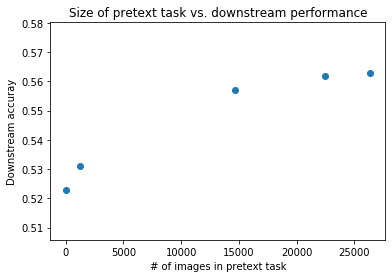

In [26]:
# No pretraining, train subset, all train, train + unsup, train + unsup + val
x = [0, 1275, 14669, 22419, 26348]
y = [0.523,  0.531, 0.557, 0.562, 0.563]
plt.title("Size of pretext task vs. downstream performance")
plt.xlabel("# of images in pretext task")
plt.ylabel("Downstream accuray")
plt.scatter(x,y)

In general adding more images to our pretext task seems to help, but the performance gains seem to be saturating.